In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.preprocessing import sequence
from IPython.display import display, Markdown

%matplotlib inline

Using TensorFlow backend.


In [12]:
from keras import models
from keras import optimizers as opt
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from attention.layers import AttentionLayer

# Please notice that this dataset is quite simple, so it's easy to overfit a model on it.
# We are using it because it comes bundled with Keras and the goal isto showcase the layer only

In [3]:
VOCAB_SIZE = 10000
MAX_LEN = 100
HIDDEN_SIZE = 16
DROPOUT = 0.5

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

x_train = sequence.pad_sequences(x_train, MAX_LEN, padding='post', truncating='post')
x_test = sequence.pad_sequences(x_test, MAX_LEN, padding='post', truncating='post')

In [4]:
def build_model():
    sentence_in = Input((MAX_LEN, ),
                        name='sentence-in')

    embedded = Embedding(VOCAB_SIZE,
                         HIDDEN_SIZE,
                         mask_zero=True,
                         name='embedding')(sentence_in)

    vectors  = LSTM(HIDDEN_SIZE,
                    return_sequences=True,
                    dropout=DROPOUT,
                    recurrent_dropout=DROPOUT,
                    name='ff-lstm')(embedded)

    sentence = AttentionLayer(name='attention')(vectors)

    output   = Dense(1,
                     activation='sigmoid',
                     name='output')(sentence)

    model = models.Model(inputs=[sentence_in], outputs=[output])
    return model

In [5]:
# (b, t, d)
model = build_model()
model.summary()
    
model.compile('adam', 'binary_crossentropy', metrics=['binary_accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence-in (InputLayer)     (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
ff-lstm (LSTM)               (None, 100, 16)           2112      
_________________________________________________________________
attention (AttentionLayer)   (None, 16)                288       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 162,417
Trainable params: 162,417
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 74s 4ms/step - loss: 0.6038 - 

In [6]:
def build_viz_model(trained_model):
    """Architecture: input -> embedding -> lstm -> attention -> sigmoid"""
    sentence_in = Input((MAX_LEN, ),
                        name='sentence-in')

    embedded = Embedding(VOCAB_SIZE,
                         HIDDEN_SIZE,
                         mask_zero=True,
                         weights=trained_model.layers[1].get_weights(),
                         name='embedding')(sentence_in)

    vectors  = LSTM(HIDDEN_SIZE,
                    return_sequences=True,
                    dropout=DROPOUT,
                    recurrent_dropout=DROPOUT,
                    weights=trained_model.layers[2].get_weights(),
                    name='ff-lstm')(embedded)

    alphas  = AttentionLayer(weights=trained_model.layers[3].get_weights(),
                              return_attention=True,
                              name='attention')(vectors)

    model = models.Model(inputs=[sentence_in], outputs=[alphas])
    return model

In [7]:
def get_index2word():
    """Computes the table that maps ids to their words."""
    INDEX_FROM = 3   # word index offset

    word2index = imdb.get_word_index()
    index2word = {v + INDEX_FROM: k for k, v in word2index.items()}
    index2word[0] = '[PAD]'
    index2word[1] = '[START]'
    index2word[2] = '[UNK]'

    return index2word


def reconstruct(sample, index2word):
    """Given a list of word ids, returns a list of words."""
    return [index2word[word] for word in sample]

In [8]:
def _weight2color(brightness):
    """Converts a single (positive) attention weight to a shade of blue."""
    brightness = brightness.item()

    brightness = int(round(255 * brightness)) # convert from 0.0-1.0 to 0-255
    ints = (255 - brightness, 255 - brightness, 255)
#     return '#%02x%02x%02x' % ints
    return 'rgba({}, {}, {}, 0.6)'.format(*ints)


def print_sentence(label, predicted, sentence, weights):
    """Prints a sample (sequence) making the most attended words background darker."""

    parts = list()
    parts.append('<span style="padding:2px;">[actual: %10s >< pred: %10s]</span> ' % (label, predicted))
    for word, weight in zip(sentence, weights):
        if word == '[PAD]':
            break
        parts.append('<span style="background: {}; color:#000; padding:2px; font-weight=\'bold\'">{}</span>'.format(_weight2color(weight), word))
    
    text = ' '.join(parts)
    display(Markdown(text))


def plot_sentence(words, weights):
    words = [f'{i}_{word}' for i, word in enumerate(words)]
    
    plt.figure(figsize=(20, 2))
    plt.plot(words, z)
    plt.xticks(rotation=90)
    plt.grid(alpha=0.4)
    plt.ylabel('Attention')
    plt.show()

In [9]:
index2word = get_index2word()
index2label = {
    0: 'negative',
    1: 'positive'
}

viz_model = build_viz_model(model)

<span style="padding:2px;">[actual:   positive >< pred:   positive]</span>  <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[START]</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">just</span> <span style="background: rgba(197, 197, 255, 0.6); color:#000; padding:2px; font-weight='bold'">brilliant</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">casting</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">location</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">scenery</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">story</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">direction</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">everyone's</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">really</span> <span style="background: rgba(235, 235, 255, 0.6); color:#000; padding:2px; font-weight='bold'">suited</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">part</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">they</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">played</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">you</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">could</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">just</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">imagine</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">being</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">there</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">robert</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">an</span> <span style="background: rgba(88, 88, 255, 0.6); color:#000; padding:2px; font-weight='bold'">amazing</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">actor</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">now</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">same</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">being</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">director</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">father</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">came</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">from</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">same</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">scottish</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">island</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">as</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">myself</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">so</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">loved</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">fact</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">there</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">real</span> <span style="background: rgba(234, 234, 255, 0.6); color:#000; padding:2px; font-weight='bold'">connection</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">with</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">witty</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">remarks</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">throughout</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">were</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">great</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">just</span> <span style="background: rgba(0, 0, 255, 0.6); color:#000; padding:2px; font-weight='bold'">brilliant</span> <span style="background: rgba(227, 227, 255, 0.6); color:#000; padding:2px; font-weight='bold'">so</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">much</span> <span style="background: rgba(234, 234, 255, 0.6); color:#000; padding:2px; font-weight='bold'">that</span> <span style="background: rgba(235, 235, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(225, 225, 255, 0.6); color:#000; padding:2px; font-weight='bold'">bought</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">as</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">soon</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">as</span> <span style="background: rgba(228, 228, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(203, 203, 255, 0.6); color:#000; padding:2px; font-weight='bold'">released</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">for</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">would</span> <span style="background: rgba(157, 157, 255, 0.6); color:#000; padding:2px; font-weight='bold'">recommend</span> <span style="background: rgba(222, 222, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(221, 221, 255, 0.6); color:#000; padding:2px; font-weight='bold'">everyone</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(222, 222, 255, 0.6); color:#000; padding:2px; font-weight='bold'">watch</span> <span style="background: rgba(228, 228, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">fly</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">fishing</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span>

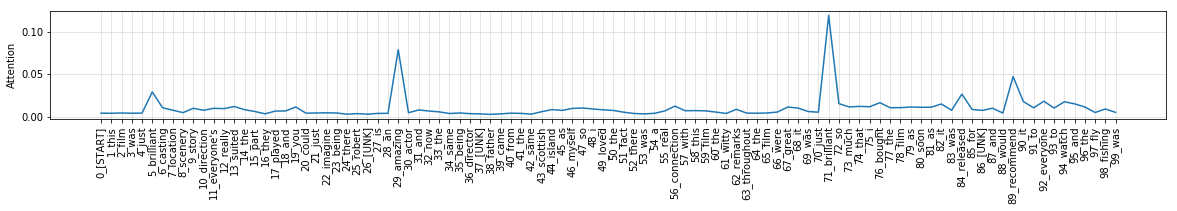

<span style="padding:2px;">[actual:   negative >< pred:   negative]</span>  <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[START]</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">big</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">hair</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">big</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">boobs</span> <span style="background: rgba(216, 216, 255, 0.6); color:#000; padding:2px; font-weight='bold'">bad</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">music</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(214, 214, 255, 0.6); color:#000; padding:2px; font-weight='bold'">giant</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">safety</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">pin</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">these</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">are</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">words</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">best</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">describe</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(188, 188, 255, 0.6); color:#000; padding:2px; font-weight='bold'">terrible</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">movie</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">love</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">cheesy</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">horror</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">movies</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i've</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">seen</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">hundreds</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">but</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">had</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">got</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">be</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">on</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(89, 89, 255, 0.6); color:#000; padding:2px; font-weight='bold'">worst</span> <span style="background: rgba(226, 226, 255, 0.6); color:#000; padding:2px; font-weight='bold'">ever</span> <span style="background: rgba(223, 223, 255, 0.6); color:#000; padding:2px; font-weight='bold'">made</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(226, 226, 255, 0.6); color:#000; padding:2px; font-weight='bold'">plot</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(200, 200, 255, 0.6); color:#000; padding:2px; font-weight='bold'">paper</span> <span style="background: rgba(106, 106, 255, 0.6); color:#000; padding:2px; font-weight='bold'">thin</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(31, 31, 255, 0.6); color:#000; padding:2px; font-weight='bold'">ridiculous</span> <span style="background: rgba(226, 226, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(226, 226, 255, 0.6); color:#000; padding:2px; font-weight='bold'">acting</span> <span style="background: rgba(235, 235, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">an</span> <span style="background: rgba(102, 102, 255, 0.6); color:#000; padding:2px; font-weight='bold'">abomination</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(190, 190, 255, 0.6); color:#000; padding:2px; font-weight='bold'">script</span> <span style="background: rgba(234, 234, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(215, 215, 255, 0.6); color:#000; padding:2px; font-weight='bold'">completely</span> <span style="background: rgba(0, 0, 255, 0.6); color:#000; padding:2px; font-weight='bold'">laughable</span> <span style="background: rgba(220, 220, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">best</span> <span style="background: rgba(223, 223, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(235, 235, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">end</span> <span style="background: rgba(235, 235, 255, 0.6); color:#000; padding:2px; font-weight='bold'">showdown</span> <span style="background: rgba(234, 234, 255, 0.6); color:#000; padding:2px; font-weight='bold'">with</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">cop</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">how</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">he</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">worked</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">out</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">who</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">killer</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it's</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">just</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">so</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">damn</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">terribly</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">written</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">clothes</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">are</span> <span style="background: rgba(180, 180, 255, 0.6); color:#000; padding:2px; font-weight='bold'">sickening</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">funny</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">equal</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(234, 234, 255, 0.6); color:#000; padding:2px; font-weight='bold'">hair</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">big</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">lots</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">boobs</span>

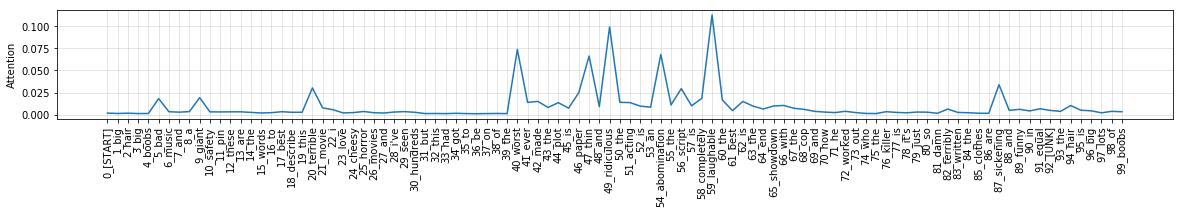

<span style="padding:2px;">[actual:   negative >< pred:   negative]</span>  <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[START]</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">has</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">be</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">one</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(60, 60, 255, 0.6); color:#000; padding:2px; font-weight='bold'">worst</span> <span style="background: rgba(215, 215, 255, 0.6); color:#000; padding:2px; font-weight='bold'">films</span> <span style="background: rgba(225, 225, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(225, 225, 255, 0.6); color:#000; padding:2px; font-weight='bold'">1990s</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">when</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">my</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">friends</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">were</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">watching</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">being</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">target</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">audience</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">aimed</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">at</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">we</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">just</span> <span style="background: rgba(157, 157, 255, 0.6); color:#000; padding:2px; font-weight='bold'">sat</span> <span style="background: rgba(233, 233, 255, 0.6); color:#000; padding:2px; font-weight='bold'">watched</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">first</span> <span style="background: rgba(220, 220, 255, 0.6); color:#000; padding:2px; font-weight='bold'">half</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">an</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">hour</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">with</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">our</span> <span style="background: rgba(219, 219, 255, 0.6); color:#000; padding:2px; font-weight='bold'">jaws</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">touching</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">floor</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">at</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">how</span> <span style="background: rgba(212, 212, 255, 0.6); color:#000; padding:2px; font-weight='bold'">bad</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">really</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(183, 183, 255, 0.6); color:#000; padding:2px; font-weight='bold'">rest</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">time</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">everyone</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">else</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">theatre</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">just</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">started</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">talking</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">each</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">other</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">leaving</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">or</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">generally</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">crying</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">into</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">their</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">popcorn</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">that</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">they</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">actually</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">paid</span> <span style="background: rgba(204, 204, 255, 0.6); color:#000; padding:2px; font-weight='bold'">money</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">they</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">had</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">working</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">watch</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(114, 114, 255, 0.6); color:#000; padding:2px; font-weight='bold'">feeble</span> <span style="background: rgba(0, 0, 255, 0.6); color:#000; padding:2px; font-weight='bold'">excuse</span> <span style="background: rgba(218, 218, 255, 0.6); color:#000; padding:2px; font-weight='bold'">for</span> <span style="background: rgba(230, 230, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(234, 234, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">must</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">have</span> <span style="background: rgba(169, 169, 255, 0.6); color:#000; padding:2px; font-weight='bold'">looked</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">like</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">great</span> <span style="background: rgba(228, 228, 255, 0.6); color:#000; padding:2px; font-weight='bold'">idea</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">on</span> <span style="background: rgba(214, 214, 255, 0.6); color:#000; padding:2px; font-weight='bold'">paper</span>

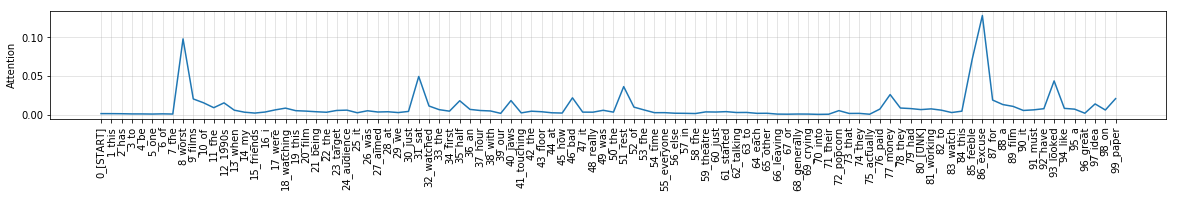

<span style="padding:2px;">[actual:   positive >< pred:   positive]</span>  <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[START]</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">at</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">storytelling</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">traditional</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">sort</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">many</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">years</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">after</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(203, 203, 255, 0.6); color:#000; padding:2px; font-weight='bold'">event</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">can</span> <span style="background: rgba(168, 168, 255, 0.6); color:#000; padding:2px; font-weight='bold'">still</span> <span style="background: rgba(203, 203, 255, 0.6); color:#000; padding:2px; font-weight='bold'">see</span> <span style="background: rgba(225, 225, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span> <span style="background: rgba(205, 205, 255, 0.6); color:#000; padding:2px; font-weight='bold'">my</span> <span style="background: rgba(229, 229, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(145, 145, 255, 0.6); color:#000; padding:2px; font-weight='bold'">eye</span> <span style="background: rgba(217, 217, 255, 0.6); color:#000; padding:2px; font-weight='bold'">an</span> <span style="background: rgba(205, 205, 255, 0.6); color:#000; padding:2px; font-weight='bold'">elderly</span> <span style="background: rgba(49, 49, 255, 0.6); color:#000; padding:2px; font-weight='bold'">lady</span> <span style="background: rgba(177, 177, 255, 0.6); color:#000; padding:2px; font-weight='bold'">my</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">friend's</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">mother</span> <span style="background: rgba(216, 216, 255, 0.6); color:#000; padding:2px; font-weight='bold'">retelling</span> <span style="background: rgba(230, 230, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(156, 156, 255, 0.6); color:#000; padding:2px; font-weight='bold'">battle</span> <span style="background: rgba(229, 229, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">she</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">makes</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">characters</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">come</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">alive</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">her</span> <span style="background: rgba(0, 0, 255, 0.6); color:#000; padding:2px; font-weight='bold'">passion</span> <span style="background: rgba(211, 211, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(219, 219, 255, 0.6); color:#000; padding:2px; font-weight='bold'">that</span> <span style="background: rgba(229, 229, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(224, 224, 255, 0.6); color:#000; padding:2px; font-weight='bold'">an</span> <span style="background: rgba(146, 146, 255, 0.6); color:#000; padding:2px; font-weight='bold'">eye</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">witness</span> <span style="background: rgba(233, 233, 255, 0.6); color:#000; padding:2px; font-weight='bold'">one</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(199, 199, 255, 0.6); color:#000; padding:2px; font-weight='bold'">events</span> <span style="background: rgba(228, 228, 255, 0.6); color:#000; padding:2px; font-weight='bold'">on</span> <span style="background: rgba(233, 233, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">heath</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">mile</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">or</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">so</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">from</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">where</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">she</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">lives</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(216, 216, 255, 0.6); color:#000; padding:2px; font-weight='bold'">course</span> <span style="background: rgba(222, 222, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">happened</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">many</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">years</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">before</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">she</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">born</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">but</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">you</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">wouldn't</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">guess</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">from</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">way</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">she</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">tells</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">same</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">story</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">told</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span> <span style="background: rgba(220, 220, 255, 0.6); color:#000; padding:2px; font-weight='bold'">bars</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(45, 45, 255, 0.6); color:#000; padding:2px; font-weight='bold'">length</span> <span style="background: rgba(196, 196, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(221, 221, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(226, 226, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(220, 220, 255, 0.6); color:#000; padding:2px; font-weight='bold'">scotland</span> <span style="background: rgba(224, 224, 255, 0.6); color:#000; padding:2px; font-weight='bold'">as</span> <span style="background: rgba(223, 223, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span>

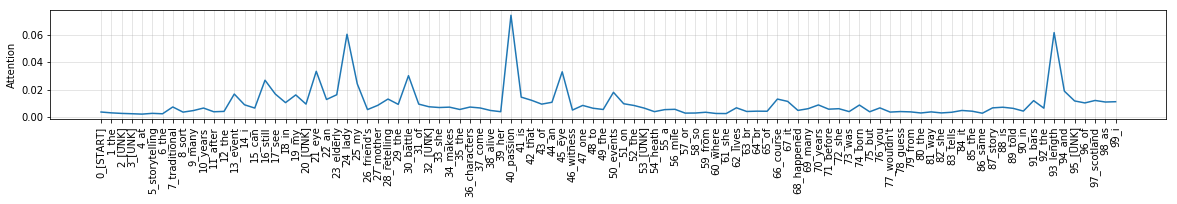

<span style="padding:2px;">[actual:   negative >< pred:   negative]</span>  <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[START]</span> <span style="background: rgba(105, 105, 255, 0.6); color:#000; padding:2px; font-weight='bold'">worst</span> <span style="background: rgba(168, 168, 255, 0.6); color:#000; padding:2px; font-weight='bold'">mistake</span> <span style="background: rgba(224, 224, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">my</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">life</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">picked</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">movie</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">up</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">at</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">target</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">for</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">5</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">because</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">figured</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">hey</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it's</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">sandler</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">can</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">get</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">some</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">cheap</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">laughs</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">wrong</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">completely</span> <span style="background: rgba(221, 221, 255, 0.6); color:#000; padding:2px; font-weight='bold'">wrong</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">mid</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">way</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">through</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">all</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">three</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">my</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">friends</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">were</span> <span style="background: rgba(217, 217, 255, 0.6); color:#000; padding:2px; font-weight='bold'">asleep</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">still</span> <span style="background: rgba(184, 184, 255, 0.6); color:#000; padding:2px; font-weight='bold'">suffering</span> <span style="background: rgba(0, 0, 255, 0.6); color:#000; padding:2px; font-weight='bold'">worst</span> <span style="background: rgba(189, 189, 255, 0.6); color:#000; padding:2px; font-weight='bold'">plot</span> <span style="background: rgba(31, 31, 255, 0.6); color:#000; padding:2px; font-weight='bold'">worst</span> <span style="background: rgba(160, 160, 255, 0.6); color:#000; padding:2px; font-weight='bold'">script</span> <span style="background: rgba(46, 46, 255, 0.6); color:#000; padding:2px; font-weight='bold'">worst</span> <span style="background: rgba(196, 196, 255, 0.6); color:#000; padding:2px; font-weight='bold'">movie</span> <span style="background: rgba(217, 217, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(215, 215, 255, 0.6); color:#000; padding:2px; font-weight='bold'">have</span> <span style="background: rgba(233, 233, 255, 0.6); color:#000; padding:2px; font-weight='bold'">ever</span> <span style="background: rgba(235, 235, 255, 0.6); color:#000; padding:2px; font-weight='bold'">seen</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(221, 221, 255, 0.6); color:#000; padding:2px; font-weight='bold'">wanted</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">hit</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">my</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">head</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">up</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">against</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">wall</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">for</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">an</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">hour</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">then</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i'd</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">stop</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">you</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">know</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">why</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">because</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">felt</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">damn</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">good</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">upon</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">bashing</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">my</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">head</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">stuck</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">that</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">damn</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">movie</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span>

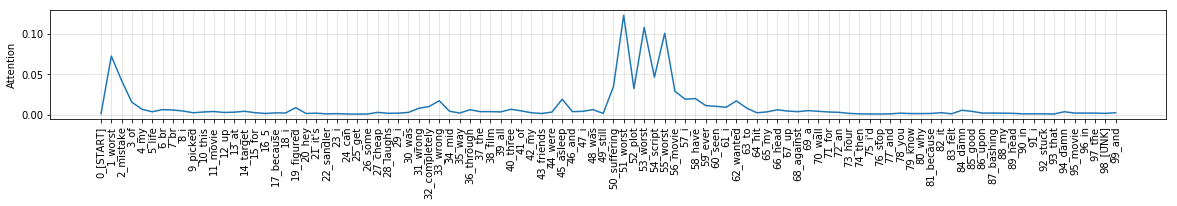

In [10]:
index2word = get_index2word()
index2label = {
    0: 'negative',
    1: 'positive'
}

for index in range(5):
    # reconstructing sample from word ids to actual words
    words = reconstruct(x_train[index], index2word)
    sample = x_train[index:index+1]

    # getting prediction and alphas
    pred = int(model.predict(sample)[0] >= 0.5)
    z = viz_model.predict(x_train[index:index+1])[0]
    
    # reescaling for visualization purposes
    w = (z - np.min(z)) / (np.max(z) - np.min(z))

    # ta-da
    print_sentence(index2label[y_train[index]], index2label[pred], words, w)
    plot_sentence(words, w)